Project Contributors:
- Leaticia Aidoune
- Asma Ben-zine



#Portfolio Optimization Using a Genetic Algorithm
This notebook explores different approaches to selecting an optimal stock portfolio using a Genetic Algorithm (GA), an optimization method inspired by natural evolution.

The goal is to maximize the performance of a stock portfolio, taking into account:

- past performance (momentum),

- expected returns (CAPM model),

- risk (volatility),

-  the empirical Sharpe ratio, which measures the real return adjusted for risk.

##Methodology

We implemented a genetic algorithm based on the pseudo-code of the academic paper, with the aim of optimizing stock portfolio selection.

The process follows several key steps:

- Initialization of a random population of portfolios,

- Evaluation of each portfolio using a fitness function,

- Selection of the best individuals (tournament selection),

- Crossover and mutation to generate a new generation,

- Repetition over multiple generations to converge toward an optimal solution.

We test several variants of the fitness function:

- With penalty: favors profitable but well-diversified portfolios.

- Without penalty: selects portfolios with the best return-to-risk ratio, ignoring diversification.

- Empirical fitness (Sharpe + CAPM): combines the observed real return over a period, risk, and the theoretical return estimated by the CAPM model.

## Collect Historical data

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'BRK-B', 'JNJ', 'JPM',
           'UNH', 'PG', 'MA', 'HD', 'BAC', 'DIS', 'VZ', 'ADBE', 'PFE', 'PEP']
market_index = '^GSPC'

"""
market_index = '^KS200'

tickers = [
    "005930.KS",  # Samsung Electronics
    "000660.KS",  # SK Hynix
    "035420.KS",  # NAVER
    "207940.KS",  # Samsung Biologics
    "051910.KS",  # LG Chem
    "005935.KS",  # Samsung Electronics (preferred)
    "068270.KS",  # Celltrion
    "035720.KS",  # Kakao
    "028260.KS",  # Samsung C&T
    "066570.KS",  # LG Electronics
    "003550.KS",  # LG
    "096770.KS",  # SK Innovation
    "000270.KS",  # Kia Corp
    "105560.KS",  # KB Financial Group
    "055550.KS",  # Shinhan Financial Group
    "034730.KS",  # SK Hynix Systems
    "251270.KQ",  # Netmarble
    "017670.KS",  # SK Telecom
    "010950.KS",  # S-Oil
    "018260.KS"   # Samsung SDS
]
"""
start_date = "2008-01-01"
end_date = "2018-12-31"

#start_date = '2019-01-01'
#end_date = '2023-12-31'



In [ ]:
prices = yf.download(tickers + [market_index], start=start_date, end=end_date, interval='1mo', auto_adjust=False)['Adj Close']
#  Calcul des rendements mensuels en pourcentage
returns = prices.pct_change().dropna()

[*********************100%***********************]  21 of 21 completed


In [ ]:
prices

Ticker,AAPL,ADBE,AMZN,BAC,BRK-B,DIS,GOOGL,HD,JNJ,JPM,...,META,MSFT,NVDA,PEP,PFE,PG,TSLA,UNH,VZ,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,4.068134,34.930000,3.885000,32.035831,91.000000,25.006817,14.054429,19.773241,37.615902,30.230127,...,NaN,23.455822,0.563726,41.044418,10.643440,39.478970,NaN,40.371189,14.790376,1378.550049
2008-02-01,3.757374,33.650002,3.223500,28.835857,93.489998,27.160553,11.735186,17.133799,36.912933,26.152889,...,NaN,19.570496,0.490366,41.955173,10.151359,40.139164,NaN,36.908981,13.972911,1330.630005
2008-03-01,4.312775,35.590000,3.565000,27.508001,89.459999,26.297382,10.970325,18.050180,38.902908,27.632629,...,NaN,20.498850,0.453686,43.547489,9.671054,42.498524,NaN,27.284691,14.022928,1322.699951
2008-04-01,5.227926,37.290001,3.931500,27.696609,89.139999,27.177313,14.303239,18.754610,40.234253,30.656464,...,NaN,20.599962,0.471109,41.556419,9.292156,40.666851,NaN,25.933548,14.872762,1385.589966
2008-05-01,5.672727,44.060001,4.081000,25.092205,89.959999,28.157810,14.589907,17.816875,40.024361,27.890287,...,NaN,20.455521,0.566248,41.416973,8.945607,40.289791,NaN,27.189295,15.041837,1400.380005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,53.845982,263.510010,100.635498,26.264112,208.720001,108.475624,61.296944,170.272156,110.716057,94.418663,...,174.905670,104.614738,6.949124,91.895370,29.124578,69.824890,20.110666,242.649734,37.864822,2901.520020
2018-09-01,53.586163,269.950012,100.150002,25.015863,214.110001,113.239960,60.066822,176.583542,114.333534,92.984818,...,163.688553,106.924545,6.961348,91.723099,31.176533,70.060585,17.651333,240.462448,37.182320,2913.979980
2018-10-01,51.952988,245.759995,79.900497,23.464417,205.279999,111.196724,54.269539,149.927643,115.839569,89.836967,...,151.077957,99.856667,5.222619,92.961548,30.462017,74.648224,22.488001,237.020325,39.759109,2711.739990


We calculate cumulative returns to visualize the portfolio's overall performance over time and compare it to a benchmark.

As in the article, monthly returns are calculated based on month-to-month price changes, using the formula.

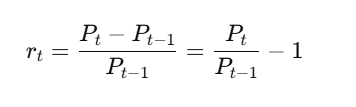

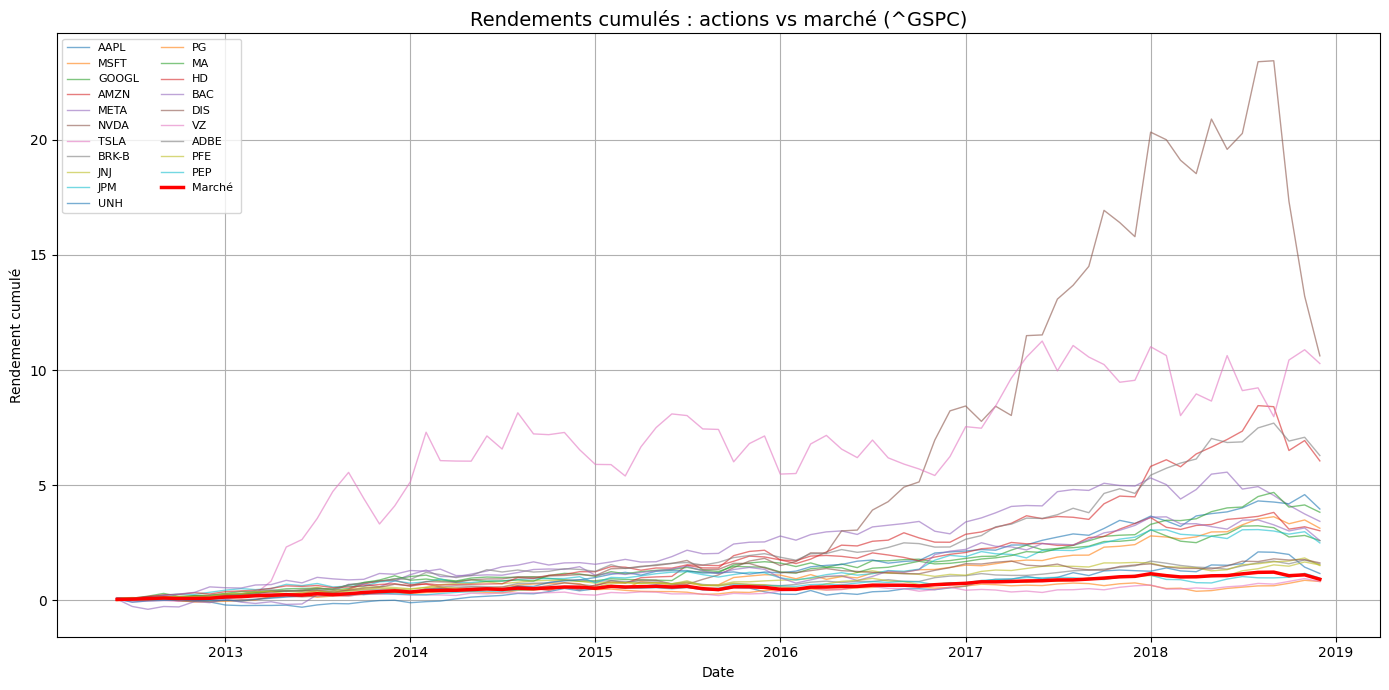

In [ ]:
#Calculates cumulative returns to visualize the growth of each investment over the period.
cumulative_returns = (1 + returns).cumprod() - 1

# Tracé du graphique
plt.figure(figsize=(14, 7))
plt.title("Rendements cumulés : actions vs marché (^GSPC)", fontsize=14)

# Tracer chaque action (en discret)
for stock in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[stock], alpha=0.6, linewidth=1, label=stock)

# Tracer le marché en rouge plus visible
plt.plot(cumulative_returns.index, cumulative_returns[market_index], color='red', linewidth=2.5, label='Marché ')

# Mise en forme
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.legend(loc='upper left', fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
returns.head()

Ticker,AAPL,ADBE,AMZN,BAC,BRK-B,DIS,GOOGL,HD,JNJ,JPM,...,META,MSFT,NVDA,PEP,PFE,PG,TSLA,UNH,VZ,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-01,0.010853,0.042512,0.072519,0.114423,0.050025,0.061037,-0.001360,0.080313,0.092707,0.077828,...,0.050676,0.054838,0.111827,0.049560,0.062091,-0.016696,0.060678,0.048951,0.067243,0.039555
2012-07-01,0.045821,-0.046030,0.021677,-0.102690,0.018121,0.013196,0.091196,-0.015286,0.024570,0.007557,...,-0.301929,-0.036613,-0.020261,0.029295,0.045217,0.053714,-0.123682,-0.123439,0.015752,0.012598
2012-08-01,0.089201,0.012630,0.064166,0.088556,-0.005893,0.006716,0.082342,0.087582,-0.025859,0.040268,...,-0.168125,0.045809,0.036189,-0.004125,-0.007487,0.050091,0.040117,0.062830,-0.038023,0.019763
2012-09-01,0.007102,0.037416,0.024369,0.105132,0.045767,0.056802,0.101315,0.069260,0.031235,0.089930,...,0.199336,-0.027997,-0.049181,-0.022919,0.051111,0.032296,0.026648,0.020442,0.061248,0.024236
2012-10-01,-0.107600,0.049014,-0.084264,0.056813,-0.020975,-0.060444,-0.098343,0.016730,0.027717,0.029644,...,-0.025392,-0.040994,-0.101949,-0.014303,0.000805,-0.001730,-0.039276,0.014741,-0.020408,-0.019789


##Calcul dynamique des bêtas CAPM glissants

Le bêta
𝛽 d'une action mesure à quel point cette action réagit aux variations du marché. Il est défini par la formule :

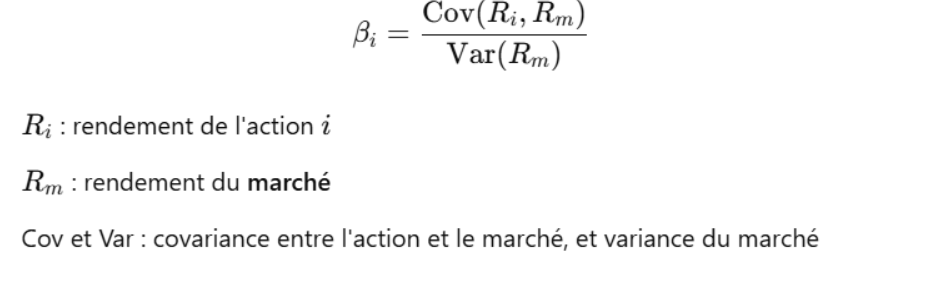

In [ ]:
# cette fonction calcule le bêta de chaque action en utilisant la régresison linéaire sur 36 mois
#le bêta mesure la sensibilité du rendement d'une action par rapport au rendement du marché
#pour chaque mois ( à partit du mois 36), on effecture une régression
#          stock_return = alpha + beta * market_return

def compute_dynamic_betas(returns, market_col=market_index, window=36):
    betas = pd.DataFrame(index=returns.index, columns=returns.columns.drop(market_col))

    for date in returns.index[window:]:
        window_data = returns.loc[:date].iloc[-window:]
        market_ret = window_data[market_col].values.reshape(-1, 1)

        for stock in betas.columns:
            stock_ret = window_data[stock].values
            model = LinearRegression().fit(market_ret, stock_ret)
            betas.at[date, stock] = model.coef_[0]

    return betas.dropna()

In [ ]:
betas = compute_dynamic_betas(returns, market_col=market_index)
betas

Ticker,AAPL,ADBE,AMZN,BAC,BRK-B,DIS,GOOGL,HD,JNJ,JPM,MA,META,MSFT,NVDA,PEP,PFE,PG,TSLA,UNH,VZ
Date,,,,,,,,,,,,,,,,,,,,
2015-06-01,1.120798,1.275205,1.397704,0.696467,1.028108,1.395183,0.914711,1.231998,0.960707,1.287582,1.317985,0.661364,0.76522,1.546423,0.831535,0.8312,1.03343,1.167391,0.706806,0.675966
2015-07-01,1.099319,1.267833,1.471584,0.708542,1.037562,1.400684,0.982456,1.24222,0.963085,1.2805,1.321197,0.68892,0.779987,1.535023,0.839387,0.850364,1.018621,1.138306,0.699645,0.673045
2015-08-01,1.078465,1.212016,1.351604,0.854452,1.04494,1.600506,0.862991,1.051676,0.991047,1.235697,1.278504,0.898281,0.845202,0.908427,0.802444,1.019732,1.0144,1.318119,0.746742,0.58329
2015-09-01,1.072274,1.136588,1.33222,0.862785,1.038903,1.54589,0.826629,1.025057,0.957676,1.234576,1.265752,0.83866,0.825173,0.804836,0.784999,0.996486,0.943618,1.398367,0.747124,0.607045
2015-10-01,0.978312,1.111659,1.491083,0.917892,0.932223,1.455043,0.911065,1.00148,0.997631,1.161983,1.262193,0.848217,1.045455,0.865295,0.832718,0.997027,0.934226,0.544621,0.626314,0.665264
2015-11-01,0.976895,1.106096,1.491972,0.92019,0.941861,1.458592,0.9069,0.989746,0.992499,1.144553,1.28103,0.928373,1.017219,0.826489,0.842851,1.008471,0.941538,0.564245,0.634022,0.670559
2015-12-01,1.045563,1.08723,1.464181,0.960075,0.943512,1.506353,0.887082,0.988869,0.961407,1.145718,1.271493,0.929297,0.988652,0.796268,0.831629,0.999813,0.867732,0.567148,0.598239,0.642091
2016-01-01,1.332152,1.189432,1.625941,1.240896,0.855871,1.511379,0.860475,0.98006,0.854593,1.208569,1.340025,0.683986,0.985882,1.032589,0.735254,0.962655,0.663243,0.95466,0.637969,0.480241
2016-02-01,1.339637,1.20685,1.65131,1.278958,0.839735,1.513865,0.879179,0.987263,0.851557,1.21935,1.349933,0.728288,1.016568,1.014604,0.738244,0.969757,0.663818,0.98518,0.638105,0.464596


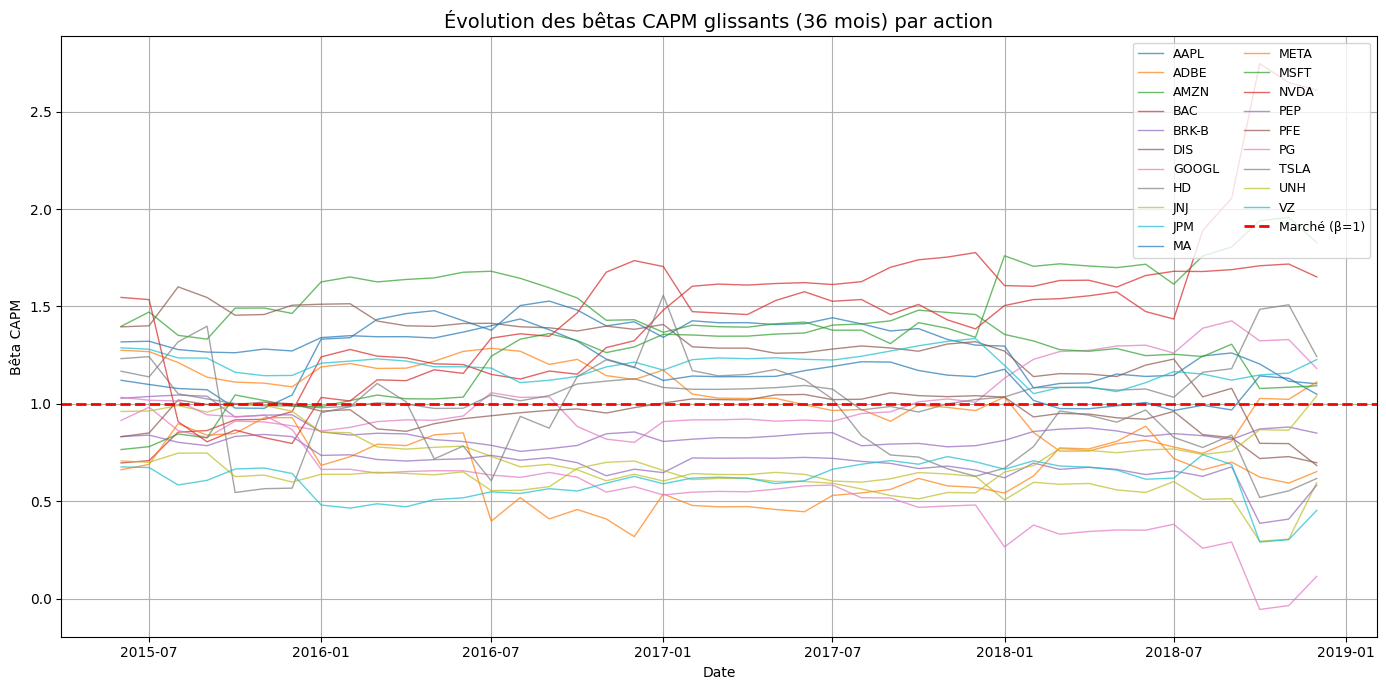

In [ ]:


plt.figure(figsize=(14, 7))
plt.title("Évolution des bêtas CAPM glissants (36 mois) par action", fontsize=14)

#
for stock in betas.columns:
    plt.plot(betas.index, betas[stock], label=stock, linewidth=1, alpha=0.7)

#  beta du marché = 1  pour comparer
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Marché (β=1)')

plt.xlabel("Date")
plt.ylabel("Bêta CAPM")
plt.legend(loc='upper right', fontsize=9, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


this graph helps visualize which stocks follow the general market trend (**curves close to the market**), which have outperformed (**above the market curve**), and which have underperformed (**below it**).

##Calculation of Expected Returns using CAPM
Le modèle CAPM prévoit le rendement attendu d’une action comme :
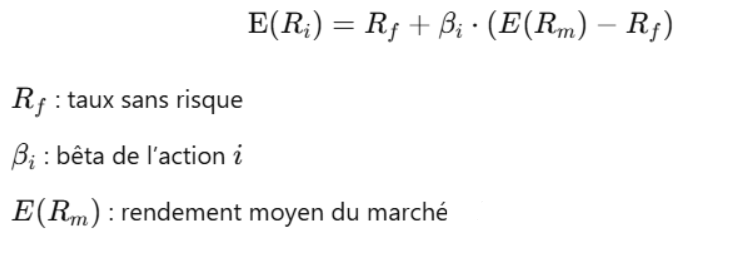

In [ ]:
#taux sans risuqe mensuel (2% / 12)
rf = 0.0016
##mpyenne glisante du rendement du marché sur 36 mois
market_returns = returns[market_index]
expected_market_return = market_returns.rolling(window=36).mean()

expected_returns = betas.copy()
expected_returns
for date in betas.index:
  if pd.notna(expected_market_return.get(date)):
     rm = expected_market_return.loc[date]
     for stock in betas.columns:
      beta = betas.at[date, stock]
      # Pour chaque mois et chaque action, on applique la formule du CAPM :
      # E(R) = Rf + β × (E(Rm) - Rf)
      # Cela donne une estimation du rendement futur attendu de chaque action en fonction de son risque (β)
      expected_returns.at[date, stock] = rf + beta * (rm - rf)

expected_returns


Ticker,AAPL,ADBE,AMZN,BAC,BRK-B,DIS,GOOGL,HD,JNJ,JPM,MA,META,MSFT,NVDA,PEP,PFE,PG,TSLA,UNH,VZ
Date,,,,,,,,,,,,,,,,,,,,
2015-06-01,0.013131,0.01472,0.01598,0.008766,0.012178,0.015954,0.011011,0.014276,0.011484,0.014847,0.01516,0.008405,0.009473,0.017511,0.010155,0.010152,0.012233,0.013611,0.008872,0.008555
2015-07-01,0.013129,0.014896,0.017033,0.009031,0.012481,0.016289,0.011903,0.014627,0.0117,0.015029,0.015455,0.008825,0.00978,0.017698,0.010403,0.010518,0.012282,0.013537,0.008937,0.008658
2015-08-01,0.010443,0.011538,0.012683,0.008606,0.010168,0.014724,0.008676,0.010223,0.009726,0.011732,0.012083,0.008966,0.00853,0.009049,0.00818,0.009962,0.009918,0.012408,0.007723,0.006383
2015-09-01,0.008883,0.00932,0.010648,0.00746,0.008656,0.0121,0.007214,0.008562,0.008105,0.009985,0.010197,0.007296,0.007205,0.007066,0.006932,0.008368,0.008009,0.011098,0.006674,0.005723
2015-10-01,0.011038,0.012324,0.015984,0.010455,0.010593,0.015636,0.010389,0.011261,0.011224,0.012809,0.013776,0.009783,0.011685,0.009947,0.009633,0.011218,0.010612,0.006854,0.007642,0.008018
2015-11-01,0.01096,0.012198,0.015896,0.010417,0.010625,0.015576,0.01029,0.011083,0.01111,0.012567,0.013874,0.010495,0.011347,0.009519,0.009676,0.011263,0.010622,0.007006,0.007675,0.008025
2015-12-01,0.010904,0.011275,0.014629,0.010143,0.009996,0.015004,0.009494,0.010399,0.010155,0.011795,0.012914,0.009869,0.010397,0.008686,0.009,0.010497,0.009321,0.006647,0.006923,0.007314
2016-01-01,0.009711,0.008842,0.011499,0.009155,0.006811,0.010802,0.006839,0.007567,0.006803,0.008958,0.009759,0.005764,0.007602,0.007887,0.006076,0.007461,0.005638,0.007412,0.005484,0.004524
2016-02-01,0.009191,0.008439,0.010957,0.008847,0.006358,0.010178,0.006582,0.007194,0.006425,0.008509,0.009249,0.005727,0.00736,0.007349,0.005783,0.007095,0.005361,0.007182,0.005216,0.004233


The average market return is estimated using a 36-month rolling average, which provides a more stable and realistic expectation of future returns in the context of the CAPM model.

## Calculation of 3-Month Cumulative Momentum Based on a 6-Month Window

Momentum measures the recent past performance of a stock.

L’article utilise un momentum sur 3 mois, calculé à partir des 6 derniers mois de rendements :
  *3-month cumulative return based on 6-month window*

In [ ]:
momentum_3m = (1 + returns[betas.columns]).rolling(window=6).apply(np.prod, raw=True) - 1
momentum_3m


Ticker,AAPL,ADBE,AMZN,BAC,BRK-B,DIS,GOOGL,HD,JNJ,JPM,MA,META,MSFT,NVDA,PEP,PFE,PG,TSLA,UNH,VZ
Date,,,,,,,,,,,,,,,,,,,,
2012-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,0.288117,0.260030,0.330761,-0.028881,0.007336,0.094614,0.115842,0.113982,0.051415,0.002484,0.229738,-0.014525,0.208775,0.161273,0.037780,0.165346,0.075871,-0.120679,0.195179,0.166577
2018-09-01,0.355377,0.249306,0.383918,-0.009958,0.073341,0.173636,0.163854,0.181394,0.093425,0.036906,0.274307,0.029226,0.263370,0.214852,0.041339,0.264557,0.069154,-0.005110,0.251706,0.143634
2018-10-01,0.334107,0.109025,0.020356,-0.072666,0.059619,0.153723,0.070687,-0.038034,0.122366,0.012762,0.111800,-0.117500,0.151473,-0.061469,0.132868,0.197776,0.248450,0.147737,0.113195,0.184976


The momentum is calculated here as the cumulative return over the past 6 months, reflecting the recent performance trend of a stock. A high score indicates that the stock has performed well over this period.

##Fitness function

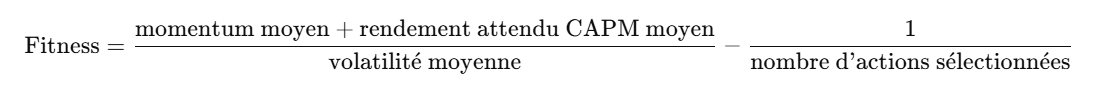

Le numérateur favorise les portefeuilles qui présentent :

- un bon rendement passé (momentum),

- une bonne estimation de rendement futur (CAPM).

Le dénominateur pénalise le risque, c’est-à-dire les portefeuilles composés d’actions très volatiles.

Enfin, le dernier terme (la pénalité) décourage la sélection d’un nombre trop faible d’actions, ce qui incite à une meilleure diversification du portefeuille.

In [ ]:
def calculate_fitness(chromosome, momentum_data, expected_returns, returns, date_eval):
    #  extraire les actions sélectionnées dans ce chromosome
    selected = [stock for bit, stock in zip(chromosome, momentum_data.columns) if bit == 1]

    if len(selected) < 3:
        return -np.inf

    try:
        #  récupérer le score de momentum (moyenne des actions sélectionnées)
        momentum_score = momentum_data.loc[date_eval, selected].mean()

        #   récupérer le rendement CAPM attendu (moyenne des actions sélectionnées)
        capm_score = expected_returns.loc[date_eval, selected].mean()

        #   mesurer le risque → volatilité sur les 3 derniers mois
        recent_returns = returns[selected].loc[:date_eval].iloc[-3:]
        #on calcule la volatilité moyenne (écart-type) des actions sélectionnées
        std_dev = recent_returns.std().mean()

        if std_dev == 0 or np.isnan(std_dev):
            return -np.inf

        # pénalité pour les portefeuilles trop concentrés
        penalty = 1 / len(selected)

        #  fonction finale = rendement attendu / risque - concentration
        fitness = (momentum_score + capm_score) / std_dev - penalty

        return fitness

    except:
        return -np.inf


In [ ]:
def calculate_fitnessSansPenalty(chromosome, momentum_data, expected_returns, returns, date_eval):
    selected = [stock for bit, stock in zip(chromosome, momentum_data.columns) if bit == 1]

    # Assurer un minimum de 1 action et un maximum de 10
    if len(selected) < 1 or len(selected) > 10:
        return -np.inf

    try:
        momentum_score = momentum_data.loc[date_eval, selected].mean()
        capm_score = expected_returns.loc[date_eval, selected].mean()
        recent_returns = returns[selected].loc[:date_eval].iloc[-3:]

        # Éviter les divisions par zéro avec un epsilon
        std_dev = recent_returns.std().mean()
        if std_dev < 1e-6:
            return -np.inf

        fitness = (momentum_score + capm_score) / (std_dev + 1e-6)
        return fitness

    except Exception as e:
        print(f"Erreur avec les actions {selected} : {e}")
        return -np.inf

##Genetic Algorithm

In [ ]:
def initialize_population(population_size, num_stocks):
    return np.random.randint(0, 2, size=(population_size, num_stocks))


In [ ]:
def tournament_selection(population, fitness_scores, k=2):
    selected_indices = np.random.choice(len(population), size=k, replace=False)
    best_idx = max(selected_indices, key=lambda i: fitness_scores[i])
    return population[best_idx].copy()


In [ ]:
def one_point_crossover(parent1, parent2):
    if len(parent1) < 2:
        return parent1.copy(), parent2.copy()

    point = np.random.randint(1, len(parent1))
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2


In [ ]:
def mutate(chromosome, mutation_rate=0.02):
    mutated = chromosome.copy()
    for i in range(len(mutated)):
        if np.random.rand() < mutation_rate:
            mutated[i] = 1 - mutated[i]
    return mutated


In [ ]:
def genetic_algorithm(momentum_data, expected_returns, returns, date_eval,
                      num_generations=30, population_size=100, mutation_rate=0.02,
                      fitness_func=calculate_fitness):

    stocks = list(momentum_data.columns)
    num_stocks = len(stocks)

    population = initialize_population(population_size, num_stocks)
    best_scores = []

    for generation in range(num_generations):
        #  Calculer le score pour chaque chromosome
        fitness_scores = [
          fitness_func(chrom, momentum_data, expected_returns, returns, date_eval)
          for chrom in population
          ]

        # Trouver le meilleur score et son portefeuille
        best_idx = np.argmax(fitness_scores)
        best_score = fitness_scores[best_idx]
        best_chromosome = population[best_idx]
        best_selected = [stock for bit, stock in zip(best_chromosome, stocks) if bit == 1]

        best_scores.append(best_score)

        #  Affichage personnalisé pour la génération
        print(f"Génération {generation+1}: Best Fitness = {best_score:.4f}")
        print(f" Meilleur portefeuille : {best_selected}\n")

        #  Génération suivante
        new_population = []
        while len(new_population) < population_size:
            parent1 = tournament_selection(population, fitness_scores)
            parent2 = tournament_selection(population, fitness_scores)
            child1, child2 = one_point_crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])

        population = np.array(new_population[:population_size])

    return population, best_scores


In [ ]:
def get_best_portfolio(population, momentum_data, expected_returns, returns, date_eval,
                       fitness_func=calculate_fitness):

    #Recherche le meilleur chromosome de la population finale selon la fonction de fitness.

    fitness_scores = [
    fitness_func(chrom, momentum_data, expected_returns, returns, date_eval)
    for chrom in population
]

    best_idx = np.argmax(fitness_scores)
    best_chromosome = population[best_idx]

    selected_stocks = [
        stock for bit, stock in zip(best_chromosome, momentum_data.columns) if bit == 1
    ]

    best_fitness = fitness_scores[best_idx]

    return selected_stocks, best_fitness


In [ ]:
import matplotlib.pyplot as plt

def plot_fitness_evolution(fitness_history, title="Évolution du fitness au fil des générations"):
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, marker='o', linestyle='-', color='blue', label='Best Fitness')
    plt.title(title)
    plt.xlabel("Génération")
    plt.ylabel("Score de fitness")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Génération 1: Best Fitness = 0.9667
 Meilleur portefeuille : ['BRK-B', 'DIS', 'MA', 'MSFT', 'PEP', 'PFE', 'UNH']

Génération 2: Best Fitness = 0.6376
 Meilleur portefeuille : ['BAC', 'BRK-B', 'GOOGL', 'HD', 'JNJ', 'MA', 'PFE', 'PG', 'UNH', 'VZ']

Génération 3: Best Fitness = 1.0223
 Meilleur portefeuille : ['BAC', 'BRK-B', 'JNJ', 'PFE', 'PG', 'TSLA', 'VZ']

Génération 4: Best Fitness = 2.1098
 Meilleur portefeuille : ['DIS', 'MSFT', 'PFE']

Génération 5: Best Fitness = 2.1098
 Meilleur portefeuille : ['DIS', 'MSFT', 'PFE']

Génération 6: Best Fitness = 2.1599
 Meilleur portefeuille : ['BRK-B', 'DIS', 'MSFT', 'PFE', 'PG', 'VZ']

Génération 7: Best Fitness = 2.0277
 Meilleur portefeuille : ['DIS', 'MSFT', 'PFE', 'VZ']

Génération 8: Best Fitness = 2.0279
 Meilleur portefeuille : ['MSFT', 'PG']

Génération 9: Best Fitness = 2.4868
 Meilleur portefeuille : ['DIS', 'PG', 'VZ']

Génération 10: Best Fitness = 2.4794
 Meilleur portefeuille : ['BRK-B', 'DIS', 'PFE', 'PG', 'VZ']

Génération 11: 

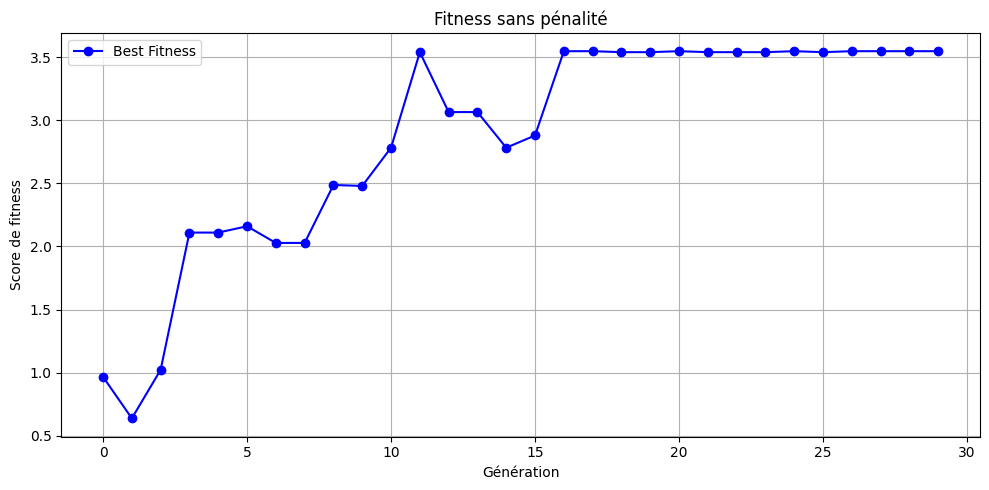

Génération 1: Best Fitness = 0.4909
 Meilleur portefeuille : ['AAPL', 'ADBE', 'BAC', 'BRK-B', 'DIS', 'JPM', 'PFE', 'PG', 'UNH', 'VZ']

Génération 2: Best Fitness = 1.0594
 Meilleur portefeuille : ['BRK-B', 'DIS', 'JPM', 'MA', 'PFE', 'PG', 'UNH']

Génération 3: Best Fitness = 1.0594
 Meilleur portefeuille : ['BRK-B', 'DIS', 'JPM', 'MA', 'PFE', 'PG', 'UNH']

Génération 4: Best Fitness = 1.1753
 Meilleur portefeuille : ['BRK-B', 'DIS', 'JPM', 'MA', 'PFE', 'PG', 'UNH', 'VZ']

Génération 5: Best Fitness = 1.1096
 Meilleur portefeuille : ['ADBE', 'BRK-B', 'DIS', 'JPM', 'PFE', 'PG', 'UNH', 'VZ']

Génération 6: Best Fitness = 1.3644
 Meilleur portefeuille : ['BRK-B', 'DIS', 'JPM', 'MA', 'PFE', 'PG', 'VZ']

Génération 7: Best Fitness = 1.6324
 Meilleur portefeuille : ['DIS', 'JNJ', 'MA', 'PFE', 'PG', 'VZ']

Génération 8: Best Fitness = 1.4757
 Meilleur portefeuille : ['DIS', 'MA', 'PEP', 'PFE', 'PG', 'VZ']

Génération 9: Best Fitness = 1.6460
 Meilleur portefeuille : ['BRK-B', 'DIS', 'MSFT', 'P

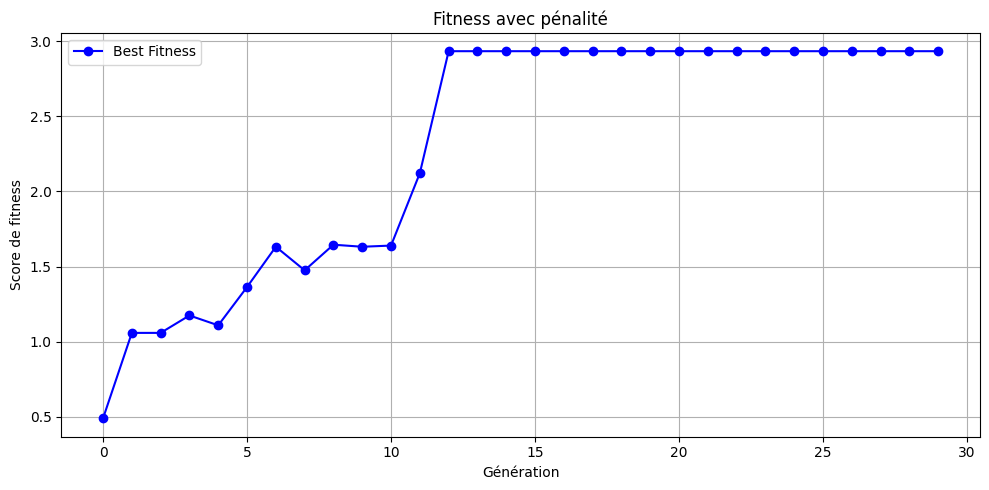

In [ ]:
#  Choix de date pour évaluation
date_eval = momentum_3m.index[-1]

# Cas sans pénalité
population, fitness_history = genetic_algorithm(momentum_3m, expected_returns, returns, date_eval,
                                                fitness_func=calculate_fitnessSansPenalty)

best_stocks, best_score = get_best_portfolio(population, momentum_3m, expected_returns, returns, date_eval,
                                             fitness_func=calculate_fitnessSansPenalty)

print("\n Meilleur portefeuille trouvé (sans pénalité) :")
print("Actions sélectionnées :", best_stocks)
print(f"Score de fitness final : {best_score:.4f}")

plot_fitness_evolution(fitness_history, title="Fitness sans pénalité")
#  Cas avec pénalité

population, fitness_history = genetic_algorithm(momentum_3m, expected_returns, returns, date_eval,
                                                fitness_func=calculate_fitness)

best_stocks, best_score = get_best_portfolio(population, momentum_3m, expected_returns, returns, date_eval,
                                             fitness_func=calculate_fitness)

print("\n Meilleur portefeuille trouvé (avec pénalité) :")
print("Actions sélectionnées :", best_stocks)
print(f"Score de fitness final : {best_score:.4f}")

plot_fitness_evolution(fitness_history, title="Fitness avec pénalité")


We introduced a new *empirical fitness function* based on the **Sharpe ratio** and the **CAPM model**, in line with the article’s pseudo-code.

This function is characterized by:

- Realistic portfolio simulation: a fixed $10,000 budget is equally distributed among selected stocks, including transaction fees and taxes.

- Use of actual returns: portfolio return is computed from real purchase and sale prices between specific start_date and end_date.

- Risk integration: portfolio volatility is derived from the average daily returns of selected stocks.

- Empirical Sharpe ratio: measures risk-adjusted performance by comparing the portfolio return to a risk-free rate.

- Expected return via CAPM: each stock’s expected return is estimated using its beta relative to the market, adding a theoretical component to the fitness.


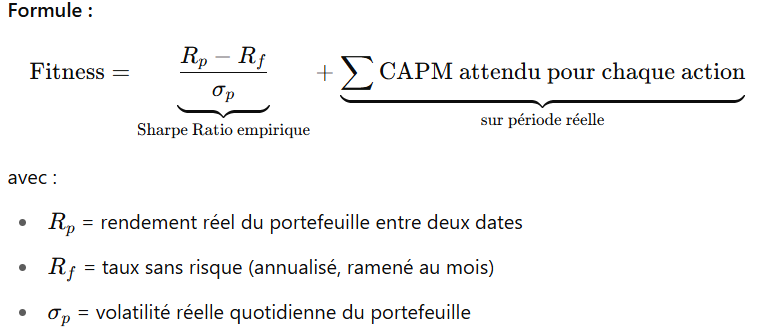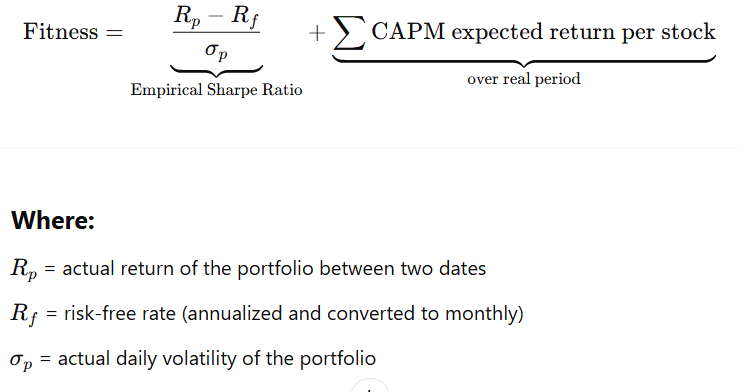

In [ ]:
def calculate_fitness_empirical_sharpe_capm(chromosome, momentum_data, expected_returns, returns, date_eval,
                                            stock_prices=None, market_prices=None, beta_values=None,
                                            start_date=None, end_date=None, risk_free_rate=0.02):

    selected = [stock for bit, stock in zip(chromosome, momentum_data.columns) if bit == 1]
    if len(selected) == 0:
        return -np.inf

    try:
        #  Préparation des prix de départ et de fin
        start_prices = stock_prices.loc[start_date, selected]
        end_prices = stock_prices.loc[end_date, selected]
        price_window = stock_prices.loc[start_date:end_date, selected]
        market_return = (market_prices.loc[end_date] - market_prices.loc[start_date]) / market_prices.loc[start_date]

        #  Simulation d’achat
        budget = 10000
        allocation = budget / len(selected)
        fees, tax = 0.00015, 0.003
        total_value = 0
        capm_total = 0
        daily_returns = []

        for stock in selected:
            if pd.isna(start_prices[stock]) or pd.isna(end_prices[stock]):
                continue

            shares = allocation / start_prices[stock]
            final_value = shares * end_prices[stock] * (1 - fees) * (1 - tax)
            total_value += final_value

            beta_series = beta_values[stock].loc[:start_date].dropna()
            if beta_series.empty:
                continue
            beta = beta_series.iloc[-1]
            expected_return = risk_free_rate + beta * (market_return - risk_free_rate)
            capm_total += expected_return

            stock_return = price_window[stock].pct_change().dropna()
            daily_returns.append(stock_return)

        if len(daily_returns) == 0:
            return -np.inf

        portfolio_return = (total_value - budget) / budget
        print(f" Gain réalisé sur {selected}: {total_value - budget:.2f} $ soit un rendement de {portfolio_return:.2%}")

        combined_returns = pd.concat(daily_returns, axis=1).mean(axis=1)
        volatility = combined_returns.std()
        sharpe_ratio = (portfolio_return - (risk_free_rate / 12)) / volatility if volatility > 0 else 0

        return sharpe_ratio + capm_total

    except Exception as e:
        print(f"Erreur fitness empirique avec {selected} : {e}")
        return -np.inf


In [ ]:
def run_ga_with_empirical_fitness(momentum_data, expected_returns, returns, prices, beta_values,
                                   market_index=market_index, risk_free_rate=0.02,
                                   num_generations=30, population_size=100, mutation_rate=0.01):
    """
    Exécute l'algorithme génétique avec une fonction de fitness empirique (Sharpe + CAPM).
    """
    stocks = list(momentum_data.columns)
    market_prices = prices[market_index]
    stock_prices = prices[stocks]

    # Définir les deux dernières dates disponibles pour la simulation réelle
    end_date_eval = momentum_data.index[-1]
    start_date_eval = momentum_data.index[-2]

    print(f"\n Période d'évaluation réelle : de {start_date_eval.date()} à {end_date_eval.date()}")

    # Fonction de fitness spécifique
    def empirical_fitness(chrom, mom, exp, ret, date):
        return calculate_fitness_empirical_sharpe_capm(
            chrom, mom, exp, ret, date,
            stock_prices=stock_prices,
            market_prices=market_prices,
            beta_values=beta_values,
            start_date=start_date_eval,
            end_date=end_date_eval,
            risk_free_rate=risk_free_rate
        )

    # Lancer l’algorithme
    population, fitness_history = genetic_algorithm(
        momentum_data, expected_returns, returns, end_date_eval,
        fitness_func=empirical_fitness,
        num_generations=num_generations,
        population_size=population_size,
        mutation_rate=mutation_rate
    )

    # Meilleur portefeuille
    best_stocks, best_score = get_best_portfolio(population, momentum_data, expected_returns, returns, end_date_eval,
                                                 fitness_func=empirical_fitness)

    print("\n Meilleur portefeuille trouvé (Fitness empirique) :")
    print("Actions sélectionnées :", best_stocks)
    print(f"Score de fitness final : {best_score:.4f}")

    plot_fitness_evolution(fitness_history, title="Fitness (Sharpe + CAPM empirique)")
    return best_stocks, best_score, fitness_history



 Période d'évaluation réelle : de 2018-11-01 à 2018-12-01
 Gain réalisé sur ['AAPL', 'AMZN', 'BAC', 'DIS', 'GOOGL', 'HD', 'META', 'PG', 'TSLA']: -755.01 $ soit un rendement de -7.55%
 Gain réalisé sur ['BAC', 'BRK-B', 'DIS', 'HD', 'JNJ', 'JPM', 'MSFT', 'PEP', 'UNH']: -931.56 $ soit un rendement de -9.32%
 Gain réalisé sur ['AAPL', 'ADBE', 'BAC', 'DIS', 'GOOGL', 'JNJ', 'MSFT', 'PEP']: -957.46 $ soit un rendement de -9.57%
 Gain réalisé sur ['ADBE', 'BRK-B', 'JNJ', 'JPM', 'MA', 'MSFT', 'NVDA', 'TSLA', 'UNH', 'VZ']: -983.17 $ soit un rendement de -9.83%
 Gain réalisé sur ['BRK-B', 'GOOGL', 'JNJ', 'META', 'PEP', 'TSLA', 'UNH', 'VZ']: -816.75 $ soit un rendement de -8.17%
 Gain réalisé sur ['AAPL', 'ADBE', 'BAC', 'BRK-B', 'GOOGL', 'MA', 'PEP', 'PG', 'TSLA', 'VZ']: -797.32 $ soit un rendement de -7.97%
 Gain réalisé sur ['AAPL', 'ADBE', 'BRK-B', 'DIS', 'JPM', 'MA', 'MSFT', 'NVDA', 'PFE', 'PG']: -877.83 $ soit un rendement de -8.78%
 Gain réalisé sur ['AAPL', 'ADBE', 'AMZN', 'DIS', 'GOOGL', 

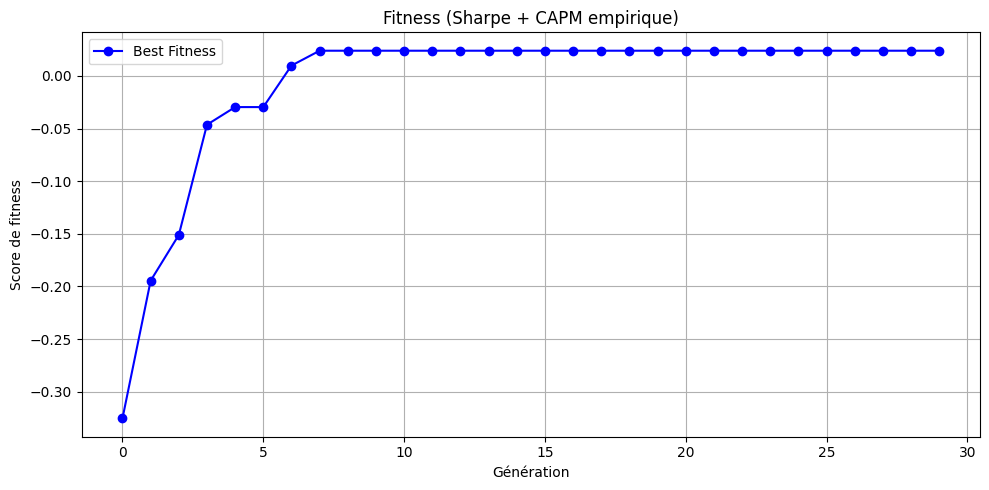

In [ ]:
# Recalculer les beta glissants sur 36 mois
def calculate_dynamic_betas(returns, market_col=market_index, window=36):
    betas = pd.DataFrame(index=returns.index, columns=returns.columns.drop(market_col))
    for date in returns.index[window:]:
        window_data = returns.loc[:date].iloc[-window:]
        market_ret = window_data[market_col].values.reshape(-1, 1)
        for stock in betas.columns:
            stock_ret = window_data[stock].values
            model = LinearRegression().fit(market_ret, stock_ret)
            betas.at[date, stock] = model.coef_[0]
    return betas.dropna()

beta_values = calculate_dynamic_betas(returns)

best_stocks, best_score, fitness_history = run_ga_with_empirical_fitness(
    momentum_3m, expected_returns, returns, prices, beta_values
)


### Summary
Important: The numerical values of the fitness scores are not directly comparable across the three tested functions, because:

- The penalized and non-penalized functions use the same underlying formula.

- However the sharp + capm uses a diferent fitness function to calculate the score

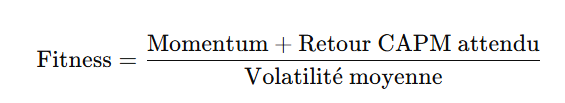


Objective: Maximize risk-adjusted return, without considering diversification.


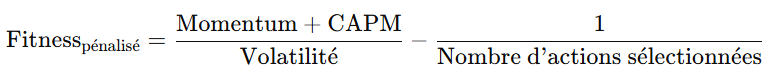

Objective: Maximize risk-adjusted return only, while penalizing overly concentrated portfolios.

Interpretation: The score favors portfolios concentrated in 1 or 2 dominant stocks (if they outperform). Risky but potentially highly profitable.



*   In contrast, the empirical Sharpe + CAPM function is different


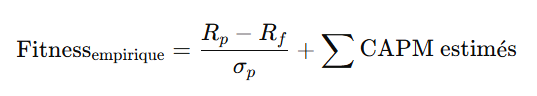

Objective: Use empirical data (real prices, historical CAPM return, volatility based on observed returns).

Interpretation: The score reflects the actual realized Sharpe ratio plus the expected CAPM return. It favors robust portfolios that align with real market dynamics.


 ## Comparative conclusion
  ###  S&P500 Market

**1. Period 2008–2018**

- **Fitness function without penalty**

**Final score**: 3.5470

**Optimal portfolio**: ['PG']

**Analysis**: The fitness function without penalty led to a high score of 3.5470, indicating that PG offers an excellent balance between expected return (momentum + CAPM) and volatility. In the absence of a concentration penalty, a single stock can dominate, especially if it has historically been stable and high-performing.

- **Fitness function with penalty**

**Final score**: 2.9332

**Optimal portfolio**: ['DIS', 'PFE', 'PG']

**Analysis**: The fitness function with penalty results in a score of 2.9332 for a portfolio composed of three stocks: PG, PFE, and DIS. This portfolio represents a trade-off between expected performance and diversification, avoiding overconcentration while maintaining a good return/risk ratio. Although the score is slightly lower than the one obtained without penalty, this portfolio is potentially more robust in the face of uncertainty due to its diversification.

- **Empirical function (Sharpe ratio + actual CAPM)**

**Final score**: 0.0240

**Optimal portfolio**: ['PG']

**Analysis**: The optimal portfolio consisting solely of PG achieves a score of 0.0240, indicating very moderate but stable performance. It combines a slight excess return relative to risk (actual Sharpe > 0) and a positive CAPM-based fundamental return, but both remain low, resulting in an overall modest score.




   **2. Période 2019–2023**

- **Fitness function with penalty**

**Final score**: 3.8021

**Optimal portfolio**: ['AMZN', 'GOOGL', 'META']

**Analysis**: This function seeks a balance between risk-adjusted return and diversification. The optimal portfolio, composed of Amazon, Google, and Meta, reflects a strategy that combines strong expected performance, controlled volatility, and moderate penalty through the selection of three stocks. The high score (3.8) indicates a good balance between performance and stability.


- **Fitness function without penalty**

**Final score**: 5.5782

**Optimal portfolio**: ['AMZN']

**Analysis**: Without a penalty, the algorithm focuses purely on the return-to-risk ratio, ignoring diversification. Amazon is the only selected asset, having outperformed others based on the
(momentum+CAPM)/volatility criterion. The high score reflects strong performance, but also a significant concentration risk.

- **Empirical function (Sharpe ratio + actual CAPM)**

**Final score**: 0.9026

**Optimal portfolio**: ['AAPL', 'ADBE', 'AMZN', 'BAC', 'BRK-B', 'DIS', 'GOOGL', 'HD', 'JNJ', 'JPM', 'MA', 'META', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'TSLA', 'UNH', 'VZ']

**Analysis**: Based on the empirical Sharpe ratio and CAPM, this function selects a diversified 20-stock portfolio across multiple sectors. The lower score (0.9) reflects a stricter but more realistic evaluation. It represents a balanced and robust strategy, suited for risk-averse investors.

  ###  KOSPI200 Market





   **Période 2019–2023**

- **Fitness function with penalty**

**Final score**: 3.3235

**Optimal portfolio**: ['000660.KS', '028260.KS', '055550.KS', '068270.KS']

- **Fitness function without penalty**

**Final score**: 4.2059

**Optimal portfolio**:['055550.KS']



#Conclusion
This comparative analysis highlights the importance of aligning the fitness function with investment objectives. While each approach yields different results depending on market conditions, combining performance, risk, and diversification remains essential for building robust portfolios. Ultimately, no single method is universally optimal,context and strategy matter.
